# **Malicious URL Detection using Machine Learning**
**Dataset Source:** Malicious URLs dataset  
**Goal:** Identify and classify malicious URLs using machine learning models.  
**Dataset Size:** 651,191 URLs  
**Classes:**  
- **Benign (Safe):** 428,103 URLs  
- **Defacement:** 96,457 URLs  
- **Phishing:** 94,111 URLs  
- **Malware:** 32,520 URLs  


**1. Installing Packages and Importing Required Libraries**

In [1]:
!pip install tldextract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 6.7 MB/s eta 0:00:00


In [2]:
# GPU-Accelerated Libraries
import cudf
import cuml
from cuml.decomposition import PCA as cuPCA
from cuml.manifold import TSNE as cuTSNE
from cuml.svm import SVC
import cupy as cp

# Standard Libraries
import numpy as np
import pandas as pd
import string
import re

# URL Parsing
from urllib.parse import urlparse
from tldextract import extract

# Machine Learning Libraries
import joblib
import gdown

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc,
    PrecisionRecallDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.preprocessing import label_binarize, LabelBinarizer

In [3]:
malicious_phish_file_id = '1PaCGbSShjI0EAmph3-5ZNmwdC89Rz--6'
malicious_phish_url = f'https://drive.google.com/uc?id={malicious_phish_file_id}'
gdown.download(malicious_phish_url, 'malicious_phish.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1PaCGbSShjI0EAmph3-5ZNmwdC89Rz--6
To: /content/malicious_phish.csv
100%|██████████| 45.7M/45.7M [00:01<00:00, 37.8MB/s]


'malicious_phish.csv'

**2. Feature Engineering Functions**

In [4]:
# Function to get URL length
def get_url_length(url):
    prefixes = ['http://', 'https://']
    for prefix in prefixes:
        if url.startswith(prefix):
            url = url[len(prefix):]
    url = url.replace('www.', '')
    return len(url)

**2.2. Extract Primary Domain**

In [5]:
# Function to extract primary domain
def extract_pri_domain(url):
    try:
        res = extract(url)
        return res.registered_domain
    except:
        return None

**2.3. Count Letters, Digits, and Special Characters**

In [6]:
# Function to count letters in URL
def count_letters(url):
    return sum(char.isalpha() for char in url)

# Function to count digits in URL
def count_digits(url):
    return sum(char.isdigit() for char in url)

# Function to count special characters in URL
def count_special_chars(url):
    special_chars = set(string.punctuation)
    return sum(char in special_chars for char in url)

**2.4. Detect URL-Based Threat Indicators**

In [7]:
# Function to check if URL uses a shortening service
def has_shortening_service(url):
    pattern = re.compile(r'bit\.ly|goo\.gl|shorte\.st|t\.co|tinyurl')
    return int(bool(pattern.search(url)))

# Function to check if URL is abnormal
def abnormal_url(url):
    parsed_url = urlparse(url)
    return int(parsed_url.netloc in url)

# Function to check if URL uses HTTPS
def secure_http(url):
    return int(urlparse(url).scheme == 'https')

# Function to check if URL contains an IP address
def have_ip_address(url):
    try:
        ip = urlparse(url).hostname
        return int(bool(ip and re.match(r'^(\d{1,3}\.){3}\d{1,3}$', ip)))
    except:
        return 0

**3. Data Preprocessing**

**3.1. Load Dataset**

In [8]:
# Load dataset
data = pd.read_csv('malicious_phish.csv')

**3.2. Apply Feature Engineering**

In [9]:
# Preprocessing function
def preprocess_data(data):
    data['url_len'] = data['url'].apply(get_url_length)
    data['pri_domain'] = data['url'].apply(extract_pri_domain)
    data['letters_count'] = data['url'].apply(count_letters)
    data['digits_count'] = data['url'].apply(count_digits)
    data['special_chars_count'] = data['url'].apply(count_special_chars)
    data['shortened'] = data['url'].apply(has_shortening_service)
    data['abnormal_url'] = data['url'].apply(abnormal_url)
    data['secure_http'] = data['url'].apply(secure_http)
    data['have_ip'] = data['url'].apply(have_ip_address)

    # Convert categorical feature 'pri_domain' to numeric using factorization
    data['pri_domain'], _ = pd.factorize(data['pri_domain'], sort=True)

    # Fill NaN values with 0
    data.fillna(0, inplace=True)

    return data.drop(columns=['url'])

# Preprocess data
data = preprocess_data(data)

**3.3. Prepare Features (X) and Target Variable (y)**

In [10]:
# Prepare features and target variable
X = data.drop(columns=['type'])
y = data['type']

# Convert categorical columns to numeric (factorization)
for col in X.columns:
    if X[col].dtype == 'object':
        X[col], _ = pd.factorize(X[col], sort=True)

X.fillna(0, inplace=True)

# Convert all features to float32
X = X.astype(np.float32)

# Convert labels to numeric encoding
y, _ = pd.factorize(y, sort=True)
y = y.astype(np.int32)

**3.4. Train-Test Split**

In [11]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**4. Model Training**

**4.1. Train Machine Learning Models**

In [12]:
# Train models
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

**4.2. Create an Ensemble Model**

In [13]:
ensemble_model = VotingClassifier(
    estimators=[('svm', svm_model), ('rf', rf_model)],
    voting='soft'
)
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('svm', SVC()),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft')

**5. Model Evaluation**

**5.1. Save Trained Models**

In [14]:
# Save models
joblib.dump(svm_model, 'svm_model.joblib')

['svm_model.joblib']

In [15]:
joblib.dump(rf_model, 'rf_model.joblib')

['rf_model.joblib']

In [16]:
joblib.dump(ensemble_model, 'ensemble_model.joblib')

['ensemble_model.joblib']

**5.2. Generate Predictions**

In [17]:
# Predictions
y_pred_svm = svm_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_ensemble = ensemble_model.predict(X_test)

# Adjust SVM predictions using precision-recall curve
y_scores = svm_model.predict_proba(X_test)

**6. Performance Visualization**


**6.1. Confusion Matrices**

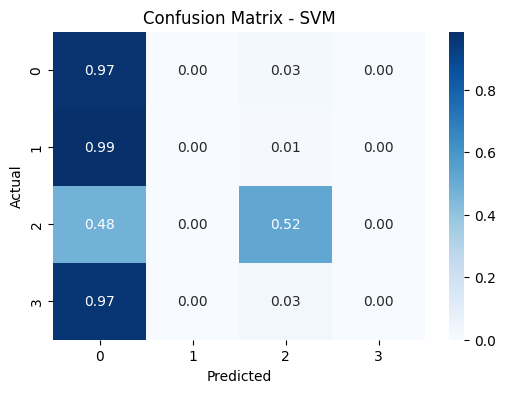

In [18]:
# Function to plot and save confusion matrix
def plot_confusion_matrix(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(f'confusion_matrix_{model_name}.png')
    plt.show()
    plt.close()

# Plot confusion matrices
plot_confusion_matrix('SVM', y_test, y_pred_svm)

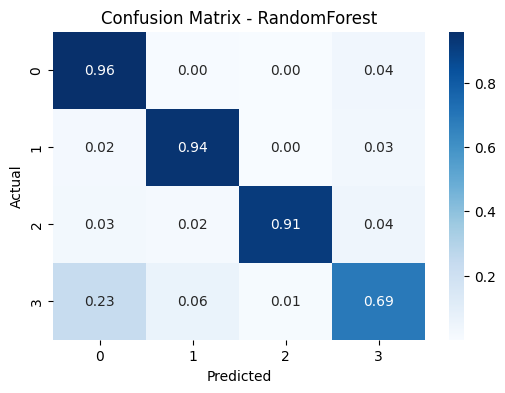

In [19]:
plot_confusion_matrix('RandomForest', y_test, y_pred_rf)

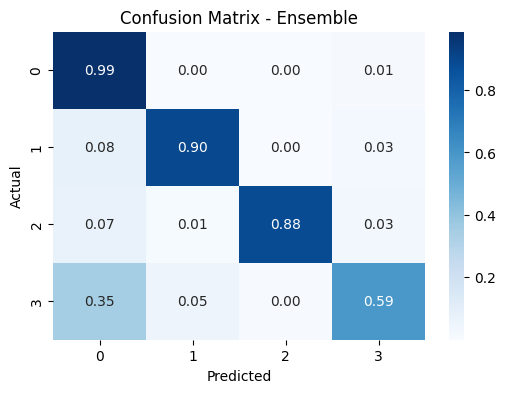

In [20]:
plot_confusion_matrix('Ensemble', y_test, y_pred_ensemble)

**6.2. Class-wise F1 Score Visualization**

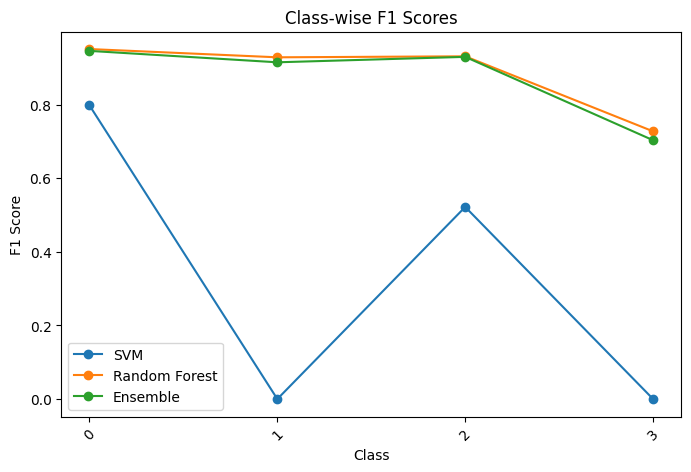

In [21]:
# Compute F1 scores
f1_scores = {
    'SVM': f1_score(y_test, y_pred_svm, average=None),
    'Random Forest': f1_score(y_test, y_pred_rf, average=None),
    'Ensemble': f1_score(y_test, y_pred_ensemble, average=None),
}

# Plot F1 scores
plt.figure(figsize=(8, 5))
for model, scores in f1_scores.items():
    plt.plot(np.arange(len(scores)), scores, marker='o', label=model)

plt.xticks(np.arange(len(scores)), labels=np.unique(y_test), rotation=45)
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('Class-wise F1 Scores')
plt.legend()
plt.savefig('f1_scores_comparison.png')
plt.show()

**7. Additional Insights & Feature Analysis**

**7.1. Feature Importance Plot (Random Forest)**

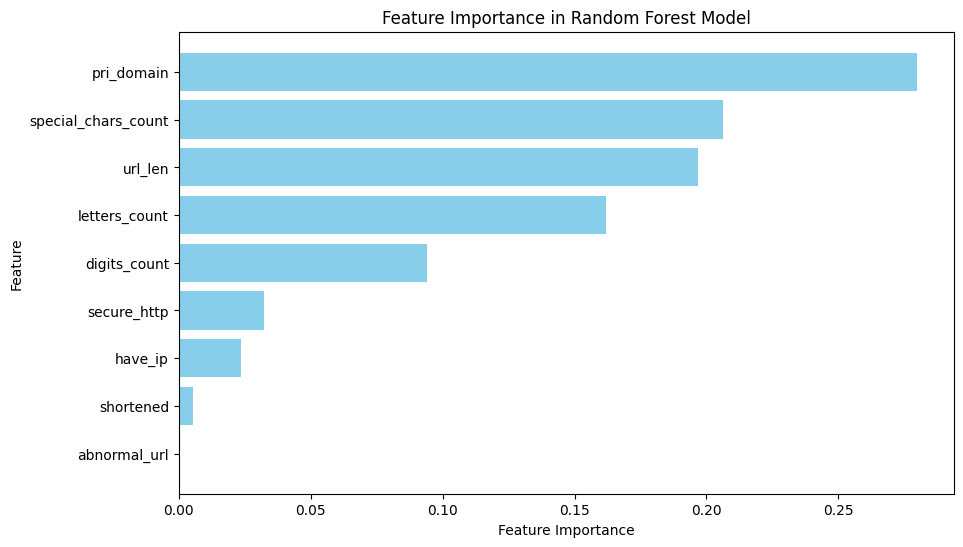

In [22]:
feature_importances = rf_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = [X.columns[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, feature_importances[sorted_indices], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest Model")
plt.gca().invert_yaxis()
plt.savefig("feature_importance_rf.png")
plt.show()

**7.2. PCA and t-SNE Visualization**

In [23]:
# Convert Pandas dataframe to RAPIDS cuDF for GPU acceleration
X_cudf = cudf.DataFrame(X)

**Ensure y is a Pandas Series for compatibility with Plotly**

In [24]:
y_series = pd.Series(y)  # Convert NumPy array back to Pandas Series

**Normalize Features (Best Practice for PCA/t-SNE)**

In [25]:
X_cudf = (X_cudf - X_cudf.mean()) / X_cudf.std()

In [27]:
# Select a random subset (max 10,000 samples or 30% of data)
subset_size = min(10000, int(0.3 * len(X_cudf)))
X_subset = X_cudf.sample(n=subset_size, random_state=42)

# Convert cuDF index to NumPy before using it with Pandas
y_subset = y_series.iloc[X_subset.index.to_numpy()]

In [29]:
# Apply t-SNE on the subset
tsne_gpu = cuTSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_gpu = tsne_gpu.fit_transform(X_subset).to_pandas()

/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:405: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


**GPU-Accelerated t-SNE**

In [30]:
# Plot t-SNE visualization
fig_tsne_gpu = px.scatter(
    x=X_tsne_gpu[0],
    y=X_tsne_gpu[1],
    color=y_subset.astype(str),
    title="2D t-SNE Visualization (GPU-Accelerated with RAPIDS, Random Subset)",
    labels={'x': 't-SNE Component 1', 'y': 't-SNE Component 2'}
)
fig_tsne_gpu.show()

**GPU-Accelerated PCA**

In [31]:
# Apply PCA on the subset
pca_gpu = cuPCA(n_components=2)
X_pca_gpu = pca_gpu.fit_transform(X_subset).to_pandas()

# Plot PCA visualization
fig_pca_gpu = px.scatter(
    x=X_pca_gpu[0],
    y=X_pca_gpu[1],
    color=y_subset.astype(str),
    title="2D PCA Visualization (GPU-Accelerated with RAPIDS, Random Subset)",
    labels={'x': 'PCA Component 1', 'y': 'PCA Component 2'}
)
fig_pca_gpu.show()